Note: you may need to restart the kernel to use updated packages.
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\punit\\anaconda3\\envs\\new\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Imports done
Prepare dataset and dataloader cpu
entering 3D samples
Total 3D samples: 248
Number of samples in dataset: 248
Number of batches in DataLoader: 83
#Train multiple base models for ensemble
Training model 0, epoch 1/2
Training model 0, epoch 2/2
  Model 0 Epoch 2 Batch 0/83 Loss: 0.8490
Saved base_model_0.pth
Training model 1, epoch 1/2
Training model 1, epoch 2/2
  Model 1 Epoch 2 Batch 0/83 Loss: 0.8108
Saved base_model_1.pth
Training model 2, epoch 1/2
Training model 2, epoch 2/2
  Model 2 Epoch 2 Batch 0/83 Loss: 0.8613
Saved base_model_2.pth
#Load ensemble models
#Ensemble prediction on a batch
Input min/max: tensor(-22.4676) tensor(957.1539)
Mask unique values: tensor([0., 1.])
#Evaluate and visualize
Dice score (ensemble): 0.02857142873108387


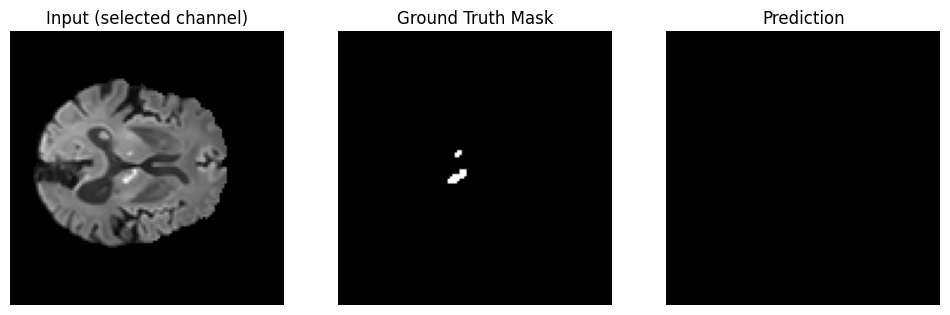

Dice score (ensemble): 1.0


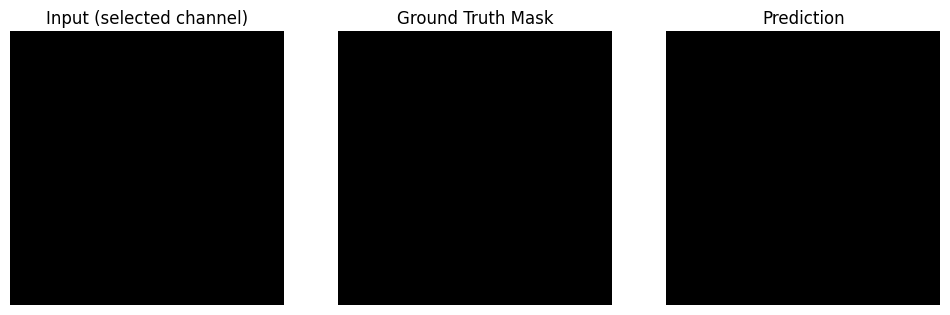

Dice score (ensemble): 1.0


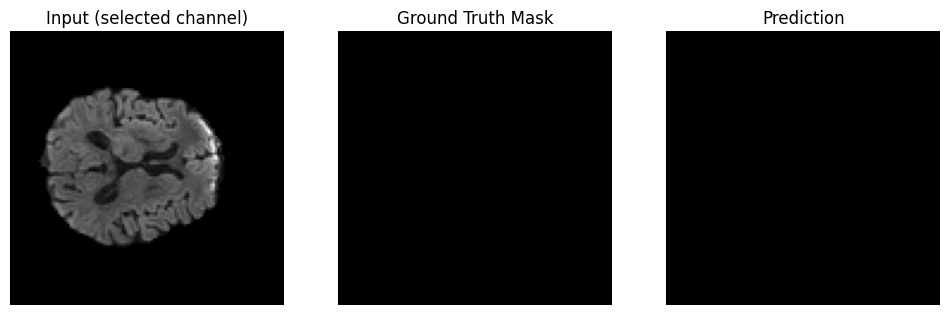

In [2]:
%pip install nibabel
%pip install opencv-python
%pip install albumentations
%pip install segmentation_models_pytorch 



import os
import torch
from torch.utils.data import DataLoader
from src.dataset import ISLESDataset3D
from src.augmentations import get_train_augmentations
from src.model import get_unet
from src.ensemble import load_ensemble, ensemble_predict
from src.utils import dice_score, plot_sample
import torch.nn.functional as F


print(f"Imports done")
# 1. Set up paths and parameters
DATA_DIR = "../data"  # or your actual data folder path
N_MODELS = 3
EPOCHS = 2
BATCH_SIZE = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Prepare dataset and dataloader",DEVICE)
def pad_collate(batch):
    xs, ys = zip(*batch)
    # Find max height, width, depth in this batch
    max_h = max(x.shape[-3] for x in xs)
    max_w = max(x.shape[-2] for x in xs)
    max_d = max(x.shape[-1] for x in xs)
    xs_padded = []
    ys_padded = []
    for x, y in zip(xs, ys):
        pad_h = max_h - x.shape[-3]
        pad_w = max_w - x.shape[-2]
        pad_d = max_d - x.shape[-1]
        # Pad as (left, right, top, bottom, front, back)
        # F.pad uses (D1, D2, H1, H2, W1, W2) for 5D tensors
        # For 4D tensors: (N, C, H, W, D) or (C, H, W, D)
        # Here, x is likely (C, H, W, D)
        x_padded = F.pad(x, (0, pad_d, 0, pad_w, 0, pad_h))
        y_padded = F.pad(y, (0, pad_d, 0, pad_w, 0, pad_h))
        xs_padded.append(x_padded)
        ys_padded.append(y_padded)
    xs_padded = torch.stack(xs_padded)
    ys_padded = torch.stack(ys_padded)
    return xs_padded, ys_padded
train_dataset = ISLESDataset3D(
    root_dir=DATA_DIR)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=pad_collate
)
print(f"Number of samples in dataset: {len(train_dataset)}")
print(f"Number of batches in DataLoader: {len(train_loader)}")

print(f"#Train multiple base models for ensemble")
for i in range(N_MODELS):
    model = get_unet(in_channels=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(EPOCHS):
        model.train()
        print(f"Training model {i}, epoch {epoch+1}/{EPOCHS}")
       # ...existing code...
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE, dtype=torch.float), y.to(DEVICE, dtype=torch.float)
        # Take the middle slice along the depth dimension
        x = x[..., x.shape[-1] // 2]
        y = y[..., y.shape[-1] // 2]
        y = y.unsqueeze(1)
        optimizer.zero_grad()
        out = model(x)
        bce = torch.nn.BCELoss()
        loss = 0.5 * bce(out, y) + 0.5 * (1 - dice_score(out, y))
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"  Model {i} Epoch {epoch+1} Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.4f}")
# ...existing code...
    torch.save(model.state_dict(), f"base_model_{i}.pth")
    print(f"Saved base_model_{i}.pth")

print(f"#Load ensemble models")
model_paths = [f"base_model_{i}.pth" for i in range(N_MODELS)]
ensemble_models = load_ensemble(model_paths, DEVICE)

print(f"#Ensemble prediction on a batch")
x, y = next(iter(train_loader))
x, y = next(iter(train_loader))
print("Input min/max:", x.min(), x.max())
print("Mask unique values:", torch.unique(y))
x = x.to(DEVICE, dtype=torch.float)
y = y.to(DEVICE, dtype=torch.float)
x = x[..., x.shape[-1] // 2]  # [B, 2, H, W]
y = y[..., y.shape[-1] // 2]  # [B, H, W]
y = y.unsqueeze(1)            # [B, 1, H, W]
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)

print(f"#Evaluate and visualize")
for i in range(min(3, x.shape[0])):  # Show up to 3 samples
    print(f"Dice score (ensemble): {dice_score(final_mask[i], y[i])}")
    plot_sample(x[i].cpu().squeeze(), y[i].cpu().squeeze(), final_mask[i].cpu().squeeze(), channel=0)  # DWI
    continue

def pad_collate(batch):
    xs, ys = zip(*batch)
    # Find max depth in this batch
    max_depth = max(x.shape[-1] for x in xs)
    xs_padded = []
    ys_padded = []
    for x, y in zip(xs, ys):
        pad_depth = max_depth - x.shape[-1]
        # Pad last dimension (depth)
        x_padded = F.pad(x, (0, pad_depth))
        y_padded = F.pad(y, (0, pad_depth))
        xs_padded.append(x_padded)
        ys_padded.append(y_padded)
    xs_padded = torch.stack(xs_padded)
    ys_padded = torch.stack(ys_padded)
    return xs_padded, ys_padded
